In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from typing import Literal

import ipywidgets as widgets
from ipywidgets import GridBox, Button
from IPython.display import display, clear_output

import os
from datetime import datetime

### Read progress and records files

In [1]:
environments = {
    "water_tank": {
        "base_dir": "../logs/ppo/double_water_tank/trainings_2",
        "tracked_point": "x2",
    },
    "CPAP": {
        # "base_dir": "../logs/ppo/CPAP/trainings",
        "base_dir": "../logs/ppo/CPAP/optuna_trainings_PID_only",
        "tracked_point": "x3",
    },
}

env_name: Literal["water_tank", "CPAP"] = "CPAP"
env = environments[env_name]
base_dir = env["base_dir"]
tracked_point = env["tracked_point"]

index = None # -1
folder_names = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))][:index]
def folder_to_datetime(folder_name):
    """
    Função para converter o nome da pasta em um objeto datetime.
    Combinada com max(), é possível ordenar de forma decrescente pastas por data da mais recente (max) para antiga (min).
    O nome da pasta DEVE estar no formato '%d-%m-%H%M' ou ter uma substring nesse formato para funcionar corretamente.
    """
    pattern = r'\d{2}-\d{2}-\d{4}'
    match = re.search(pattern, folder_name)
    if match:
        date_str = match.group(0)
        date_str = datetime.strptime(date_str, '%d-%m-%H%M')
        return (date_str.month, date_str.day)
    else:
        raise ValueError(f"Formato de data inválido na pasta: {folder_name}")


folder_names.sort(key=folder_to_datetime)

latest_folder = folder_names[-1] # max(folder_names, key=folder_to_datetime)
selected_folder = latest_folder
selected_index = len(folder_names) - 1


# print(folder_names)
# print(f"A pasta mais recente é: {latest_folder}")

NameError: name 'Literal' is not defined

In [ ]:
def are_required_files_present(folder: str):
    return all([
        os.path.exists(f"{base_dir}/{folder}/progress.csv"),
        os.path.exists(f"{base_dir}/{folder}/records.csv"),
        # os.path.exists(f"{base_dir}/{folder}/only_pid_records.csv"),
    ])

In [ ]:
def load_dfs(folder: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:

    if not are_required_files_present(folder):
        raise FileNotFoundError("Arquivos necessários não encontrados.")
    
    progress_df = pd.read_csv(f"{base_dir}/{folder}/progress.csv")
    rec_df = pd.read_csv(f"{base_dir}/{folder}/records.csv")

    # Find the index of the last episode start
    mask = rec_df["steps_in_episode"] == 1
    start_episode_indexes = mask[mask].index.to_list()
    last_episode_start_idx = start_episode_indexes[-1]

    # Filter the dataframe for the last episode
    last_episode_df = rec_df.loc[last_episode_start_idx:]

    return progress_df, rec_df, last_episode_df

progress_df, rec_df, last_episode_df = load_dfs(latest_folder)

In [ ]:
progress_df.head()

,train/iteration
0,1


In [ ]:
rec_df

,x1,x2,x3,x4,x5,x6,x7,x8,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,15.792129,0.015792,0.332238,0.000000,0.0,1.0,0.0,300.008100,3.0,2.667762,300.027600,-0.019506,300.008094,-7.116955,2.667762,1
1,240.539760,0.256332,1.769714,0.332238,0.0,1.0,0.0,268.029540,3.0,3.898049,266.828361,1.201193,268.029554,-1.513605,1.230286,2
2,462.136350,0.718468,3.212582,1.769714,0.0,1.0,0.0,125.291860,3.0,3.685467,123.092097,2.199768,125.291865,-0.045191,-0.212582,3
3,601.734860,1.320203,4.078031,3.212582,0.0,1.0,0.0,-11.138901,3.0,2.607436,-21.196668,10.057767,-11.138901,-1.162150,-1.078031,4
4,594.653600,1.914857,4.085882,4.078031,0.0,1.0,0.0,-96.321526,3.0,1.521555,-107.751484,11.429956,-96.321528,-1.179139,-1.085881,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,10.051180,237.816650,5.006742,5.013795,0.0,1.0,0.0,-1.626601,5.0,24.979464,4.397802,-6.024404,-1.626601,-0.000045,-0.006741,9996
249996,-8.615282,237.808030,4.923739,5.006742,0.0,1.0,0.0,-2.615805,5.0,25.000000,5.103167,-7.718971,-2.615805,-0.005816,0.076261,9997
249997,1.795203,237.809830,5.012950,4.923739,0.0,1.0,0.0,6.033594,5.0,24.987050,13.404116,-7.370522,6.033594,-0.000168,-0.012950,9998
249998,4.371609,237.814200,4.994529,5.012950,0.0,1.0,0.0,-2.441530,5.0,24.992521,4.482880,-6.924409,-2.441530,-0.000030,0.005471,9999


# Separa as linhas por episódio

In [ ]:
mask = rec_df["steps_in_episode"] == 1
start_episode_indexes = mask[mask].index.to_list()

first_episode_start = start_episode_indexes[0]
first_episode_end = start_episode_indexes[1] - 1 if len(start_episode_indexes) > 1 else len(rec_df) - 1

last_episode_start = start_episode_indexes[-1]
last_episode_end = len(rec_df) - 1

first_episode = rec_df.iloc[first_episode_start:first_episode_end+1]
last_episode = rec_df.iloc[last_episode_start:last_episode_end+1]

episodes_count = len(start_episode_indexes)

In [ ]:
first_episode

,x1,x2,x3,x4,x5,x6,x7,x8,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
0,15.792129,0.015792,0.332238,0.000000,0.0,1.0,0.0,300.008100,3.0,2.667762,300.027600,-0.019506,300.008094,-7.116955e+00,2.667762,1
1,240.539760,0.256332,1.769714,0.332238,0.0,1.0,0.0,268.029540,3.0,3.898049,266.828361,1.201193,268.029554,-1.513605e+00,1.230286,2
2,462.136350,0.718468,3.212582,1.769714,0.0,1.0,0.0,125.291860,3.0,3.685467,123.092097,2.199768,125.291865,-4.519100e-02,-0.212582,3
3,601.734860,1.320203,4.078031,3.212582,0.0,1.0,0.0,-11.138901,3.0,2.607436,-21.196668,10.057767,-11.138901,-1.162150e+00,-1.078031,4
4,594.653600,1.914857,4.085882,4.078031,0.0,1.0,0.0,-96.321526,3.0,1.521555,-107.751484,11.429956,-96.321528,-1.179139e+00,-1.085881,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-3.057521,244.093400,4.959918,4.920144,0.0,1.0,0.0,3.641674,5.0,25.000000,12.555043,-8.913369,3.641674,-1.606566e-03,0.040082,9996
9996,-5.976325,244.087420,4.947861,4.959918,0.0,1.0,0.0,0.537465,5.0,25.000000,8.578029,-8.040564,0.537465,-2.718529e-03,0.052140,9997
9997,1.101693,244.088520,5.000660,4.947861,0.0,1.0,0.0,3.919432,5.0,24.999340,9.784261,-5.864828,3.919432,-4.349919e-07,-0.000660,9998
9998,11.969298,244.100500,5.002755,5.000660,0.0,1.0,0.0,-2.385555,5.0,24.996586,4.504349,-6.889904,-2.385555,-7.588179e-06,-0.002755,9999


In [ ]:
last_episode

,x1,x2,x3,x4,x5,x6,x7,x8,y_ref,z_t,PID_action,PPO_action,combined_action,reward,error,steps_in_episode
240000,17.064102,0.017064,0.337810,0.000000,0.0,1.0,0.0,304.569150,3.0,2.662190,305.891583,-1.322432,304.569150,-7.087253,2.662190,1
240001,251.700410,0.268765,1.777796,0.337810,0.0,1.0,0.0,270.793520,3.0,3.884393,272.135029,-1.341506,270.793523,-1.493782,1.222204,2
240002,485.905600,0.754670,3.242242,1.777796,0.0,1.0,0.0,130.308650,3.0,3.642151,128.147704,2.160950,130.308654,-0.058681,-0.242242,3
240003,635.279400,1.389950,4.129187,3.242242,0.0,1.0,0.0,-9.760270,3.0,2.512965,-18.299108,8.538837,-9.760270,-1.275062,-1.129187,4
240004,633.368900,2.023318,4.169274,4.129187,0.0,1.0,0.0,-95.014010,3.0,1.343690,-107.003951,11.989945,-95.014006,-1.367203,-1.169275,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,10.051180,237.816650,5.006742,5.013795,0.0,1.0,0.0,-1.626601,5.0,24.979464,4.397802,-6.024404,-1.626601,-0.000045,-0.006741,9996
249996,-8.615282,237.808030,4.923739,5.006742,0.0,1.0,0.0,-2.615805,5.0,25.000000,5.103167,-7.718971,-2.615805,-0.005816,0.076261,9997
249997,1.795203,237.809830,5.012950,4.923739,0.0,1.0,0.0,6.033594,5.0,24.987050,13.404116,-7.370522,6.033594,-0.000168,-0.012950,9998
249998,4.371609,237.814200,4.994529,5.012950,0.0,1.0,0.0,-2.441530,5.0,24.992521,4.482880,-6.924409,-2.441530,-0.000030,0.005471,9999


### Plot Train over iteraçtion

In [ ]:
def plot_progress(folder: str, save = False):
    # Plotting train/loss vs train/iteration
    plt.figure(figsize=(12, 6))
    plt.plot(progress_df['train/iteration'], progress_df['train/loss'], label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss vs. Iteration')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/loss_over_iteration.png")
    else: 
        plt.show()

# plot_progress(latest_folder, save = True)

### Plote reward over steps

In [ ]:
def plot_rewards(folder: str, save=False):
    # Plotting reward vs steps
    plt.figure(figsize=(12, 6))
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['reward'], label='Reward')
    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.title('Reward vs. Steps')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/reward_over_last_episode_steps.png")
    else:
        plt.show()

# plot_rewards(latest_folder, save=True)

### Plot Set point curve

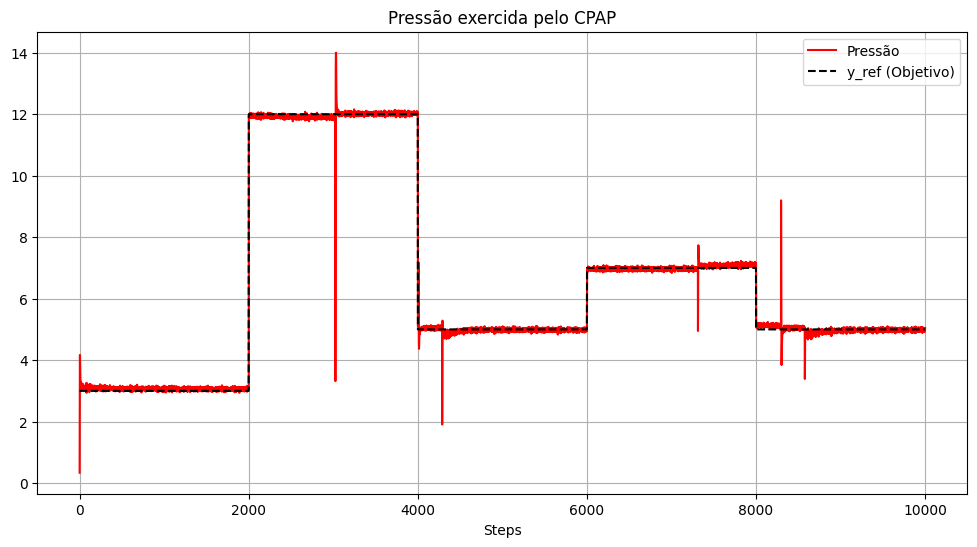

In [ ]:
def plot_tracking(folder: str, save: bool = False):
    # Plot y_ref vs steps_in_episode
    plt.figure(figsize=(12, 6))
    if env_name == "water_tank":
        plt.title('Altura da água no segundo tanque em cada passo no último episódio')
        tracked_point_label = "Altura da água no segundo tanque"
    else:
        plt.title('Pressão exercida pelo CPAP')
        tracked_point_label = "Pressão"
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df[tracked_point], label=tracked_point_label, color='red')
    plt.plot(last_episode_df['steps_in_episode'], last_episode_df['y_ref'], '--', label='y_ref (Objetivo)', color='black')
    plt.xlabel('Steps')
    plt.ylabel('')
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(f"{base_dir}/{folder}/tracking.png")
    else:
        plt.show()

plot_tracking(latest_folder, save=False)

### Ação do PPO e PID durante o último episódio

In [ ]:
def plot_action_per_steps(folder: str, save: bool = False, separated: bool = True):

    if (separated):
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PID em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PID_action.png")
        else:
            plt.show()

        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação do controlador PPO em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/PPO_action.png")
        else:
            plt.show()
    else:
        # Plotting action vs steps in the last episode
        plt.figure(figsize=(12, 6))
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PID_action'], label='PID_action', color='blue')
        plt.plot(last_episode_df['steps_in_episode'], last_episode_df['PPO_action'], label='PPO_action', color='red')
        # plt.plot(last_episode_df['steps_in_episode'], last_episode_df['action'], label='Action', color='black')
        plt.xlabel('Steps')
        plt.ylabel('Action')
        plt.title('Ação em cada passo no último episódio')
        plt.legend()
        plt.grid(True)
        if save:
            plt.savefig(f"{base_dir}/{folder}/combined_action.png")
        else:
            plt.show()

# plot_action_per_steps(latest_folder, save=True)

# Função para exibir a grade de pastas

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def display_folders_grid(folder_names: list[str], selected_indices: int = 0) -> widgets.VBox:
    num_cols = 5
    previous_selected = [selected_indices]
    
    def on_button_click(b: widgets.Button):
        global selected_folder
        selected_folder = b.description

        global progress_df, rec_df, last_episode_df
        progress_df, rec_df, last_episode_df = load_dfs(selected_folder)

        previous_selected.append(buttons.index(b))
        if len(previous_selected) > 2:
            previous_selected.pop(0)
        
        # Atualiza cor dos botões
        buttons[previous_selected[0]].button_style = '' 
        buttons[previous_selected[1]].button_style = 'success'

        clear_output(wait=True)  # Limpar as saídas anteriores
        display(grid)            # Reexibir a grade de botões
        display(save_button)     # Reexibir o botão de salvar

        plot_tracking(selected_folder, save=False)
        plot_rewards(selected_folder, save=False)
        plot_action_per_steps(selected_folder, save=False)

    def on_save_click(b: widgets.Button):
        should_save = True  # Ativar o modo de salvar
        
        if 'selected_folder' in globals():
            plot_tracking(selected_folder, save=should_save)
            plot_rewards(selected_folder, save=should_save)
            plot_action_per_steps(selected_folder, save=should_save)
            print(f"Plots salvos para {selected_folder}!")
        else:
            print("Nenhuma pasta selecionada ainda!")

    # Criar os botões para as pastas
    buttons = []
    for i, folder in enumerate(folder_names):
        button = widgets.Button(description=folder, layout=widgets.Layout(width='auto', height='auto'))
        button.on_click(on_button_click)
        buttons.append(button)
    
    # Marcar o primeiro botão como ativo
    buttons[selected_indices].button_style = 'success'  
    
    # Criar o botão de salvar
    save_button = widgets.Button(description="Salvar Gráficos", button_style='info')
    save_button.on_click(on_save_click)

    # Criar a grade de botões
    grid = widgets.GridBox(
        children=buttons,
        layout=widgets.Layout(grid_template_columns=f'repeat({num_cols}, 1fr)')
    )

    display(save_button)
    display(grid)
    display(save_button)


GridBox(children=(Button(description='02-03-0516', layout=Layout(height='auto', width='auto'), style=ButtonSty…

Button(button_style='info', description='Salvar Gráficos', style=ButtonStyle())

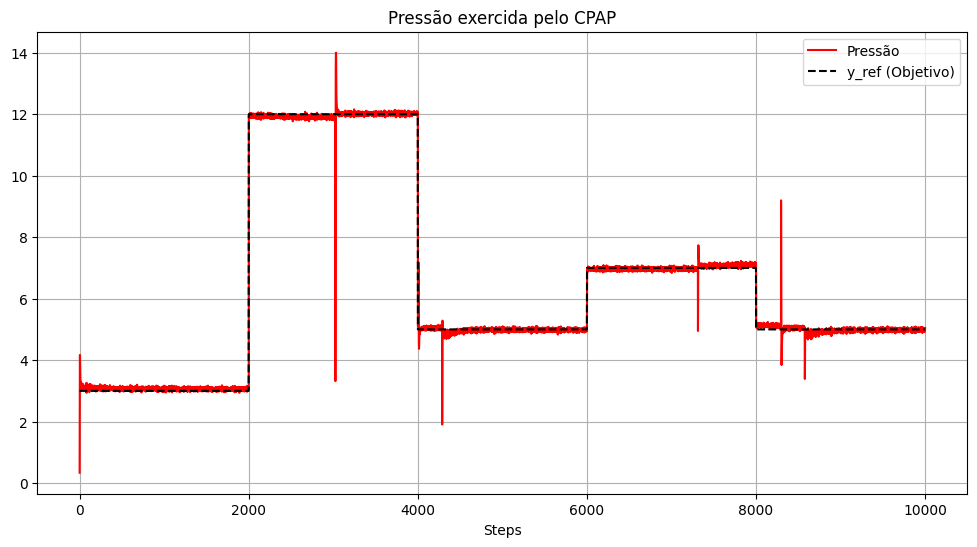

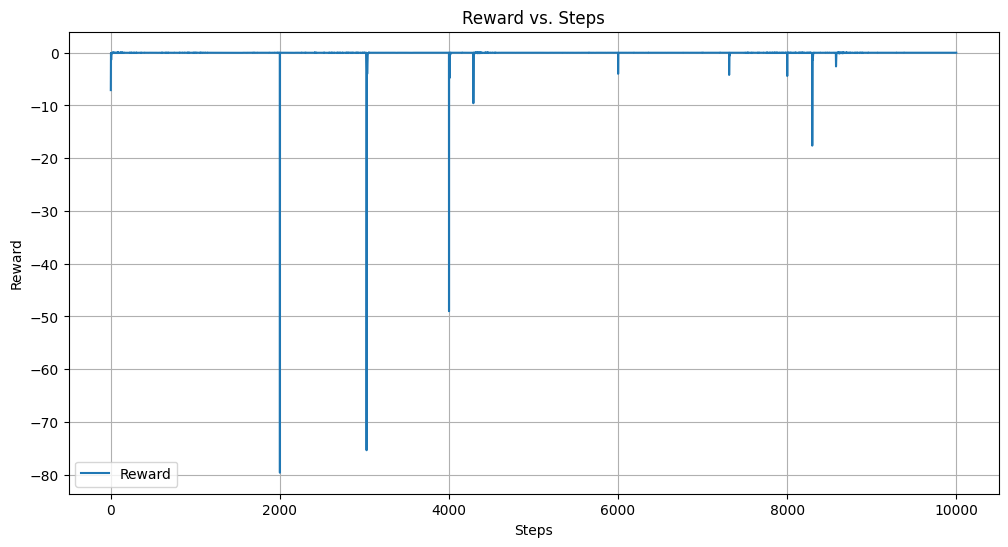

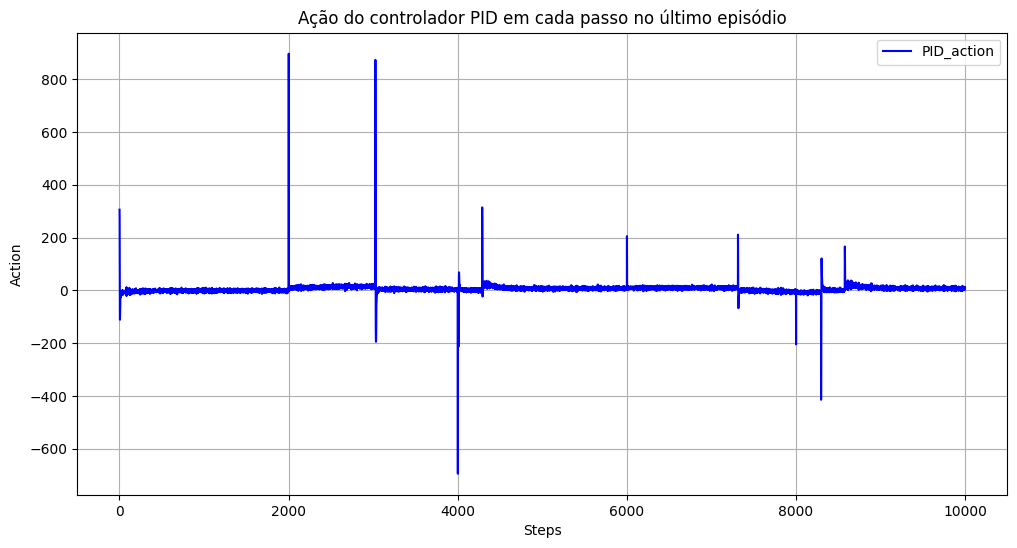

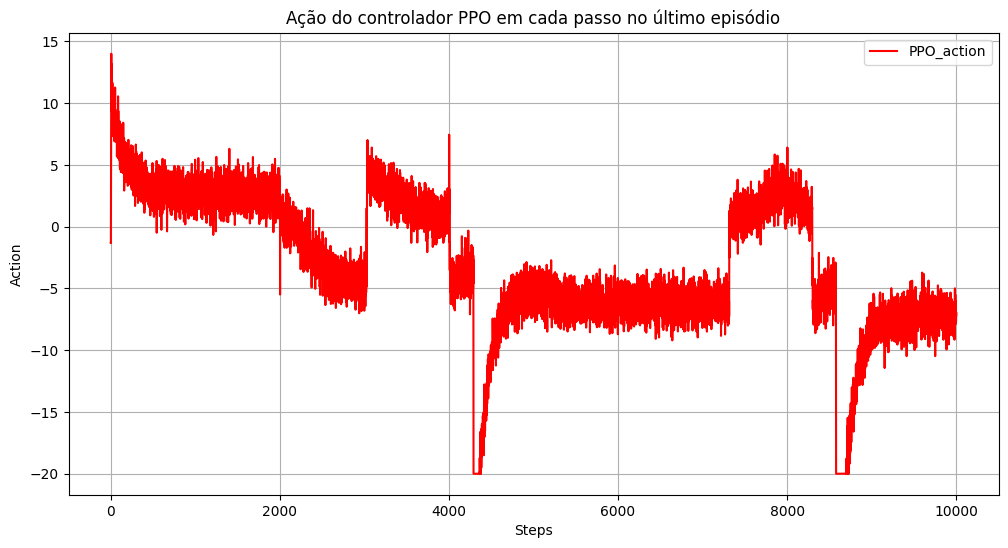

In [ ]:
# Uncomment to use widget 
display_folders_grid(folder_names, selected_index)